# メモ
- ダウンサンプリング
- ロジスティック回帰のエラスティックネット 
- kfold

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [3]:
#@title
# 以下の Repo からコピペ
# https://github.com/TeruakiUeda/faster_reduce_mem_usage/blob/main/src/reduce_mem_usage.py
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    dfs = []
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dfs.append(df[col].astype(np.int8))
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dfs.append(df[col].astype(np.int16))
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dfs.append(df[col].astype(np.int32))
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dfs.append(df[col].astype(np.int64) ) 
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dfs.append(df[col].astype(np.float16))
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dfs.append(df[col].astype(np.float32))
                else:
                    dfs.append(df[col].astype(np.float64))
        else:
            dfs.append(df[col])
    
    df_out = pd.concat(dfs, axis=1)
    if verbose:
        end_mem = df_out.memory_usage().sum() / 1024**2
        num_reduction = str(100 * (start_mem - end_mem) / start_mem)
        print(f'Mem. usage decreased to {str(end_mem)[:3]}Mb:  {num_reduction[:2]}% reduction')
    return df_out

In [4]:
def check_memory(dir_list):
    print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
    print(" ------------------------------------ ")
    for var_name in dir_list:
        if not var_name.startswith("_"):
            print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

# 設定

In [5]:
extract_num = 100
read_min = False
confirm_eda = False

In [6]:
input_path = '/content/drive/MyDrive/input/nishika_anormaly_detection/'
output_path = '/content/drive/MyDrive/output/nishika_anormaly_detection/'
interm_path = '/content/drive/MyDrive/intermediate/nishika_anormaly_detection/'
now = dt.datetime.today()
month = str(now.month)
day = str(now.day)
competition_name = 'anormaly_preciction'
comment = 'first_sub'

save_nm = f'submission_{comment}_{month}_{day}.csv'
print(save_nm)

submission_first_sub_3_31.csv


In [7]:
if read_min == True:
    train_df = pd.read_csv(input_path + 'train.csv', nrows = 1000000)
else:
    train_df = pd.read_csv(input_path + 'train.csv')
train_df['train_test'] = 'train'

if read_min == True:
    test_df = pd.read_csv(input_path + 'test.csv', nrows = 500000)
else:
    test_df = pd.read_csv(input_path + 'test.csv')

test_df['train_test'] = 'test'

gc.collect()

0

In [8]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

In [9]:
print(train_df['timestamp'].min())
print(train_df['timestamp'].max())

2015-02-06 04:44:00
2015-04-16 10:46:00


In [10]:
print(test_df['timestamp'].min())
print(test_df['timestamp'].max())

2015-06-20 20:40:00
2015-10-03 00:00:00


In [11]:
# train_df = train_df[train_df['timestamp'] < dt.datetime(2015, 4, 1)].reset_index(drop = True)
# print(train_df['timestamp'].min())
# print(train_df['timestamp'].max())

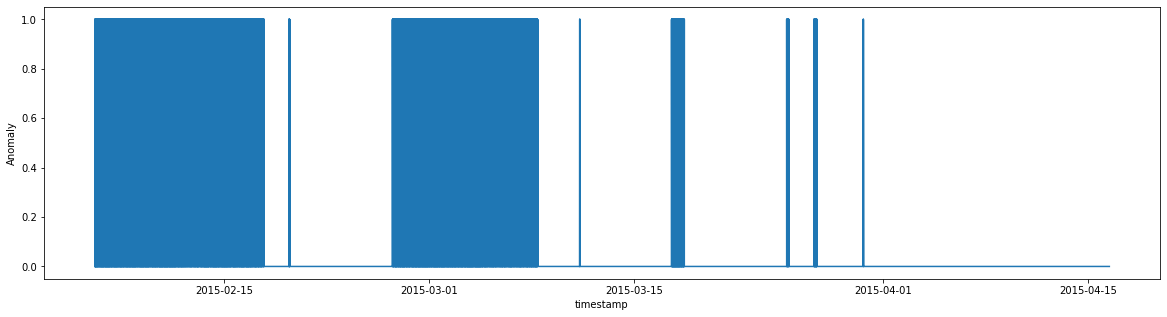

In [12]:
plt.figure(figsize = (20, 5))
plt.plot(train_df.sort_values('timestamp')['timestamp'], train_df.sort_values('timestamp')['Anomaly'])
plt.xlabel('timestamp')
plt.ylabel('Anomaly')
plt.show()

In [13]:
main_col_list = ['timestamp', 'host', 'Anomaly', 'process', 'train_test']
des_col_list = ['host', 'process']
cal_col_list = list(set(train_df.columns) - set(main_col_list))
target_col = 'Anomaly'

In [14]:
def check_corr(df, target_col, cal_col_list):

    cal_corr_anomaly_df = df[df['Anomaly'] == 1].sample(n = 1000, random_state = 42).reset_index(drop = True)
    cal_corr_nomaly_df = df[df['Anomaly'] == 0].sample(n = 1000, random_state = 42).reset_index(drop = True)
    cal_corr_df = pd.concat([cal_corr_anomaly_df, cal_corr_nomaly_df], axis = 0)
    corr_df = abs(cal_corr_df.corr()[target_col]).sort_values(ascending = False)
    
    display(corr_df.head(10))
    extract_col_list = list(corr_df.index[:extract_num])

    del cal_corr_anomaly_df, cal_corr_nomaly_df, cal_corr_df, corr_df
    gc.collect()

    return extract_col_list

In [15]:
extract_col_list = check_corr(train_df, target_col, cal_col_list)
feature_list = list(set(main_col_list) | set(extract_col_list))
print(feature_list)

Anomaly                                                                                                                                                     1.000000
Rel. swap usage : ((MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize / MXBean(java.lang:type=OperatingSystem).TotalSwapSpaceSize))                  0.658293
Stuck threads : (MXBean(com.bea:Name=ThreadPoolRuntime,Type=ThreadPoolRuntime).StuckThreadCount)                                                            0.629040
Stuck threads : (MXBean(com.bea:ApplicationRuntime=sys01,Name=default,Type=WorkManagerRuntime).StuckThreadCount)                                            0.629040
GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))                                                         0.541511
Memory space usage : ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.max))    0.497852
Memory spa

['Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))', 'Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))', 'Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)', 'Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max))', 'Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))', 'Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))', 'Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConne

In [16]:
# feature_list = list(set(main_col_list) | set(cal_col_list))

In [17]:
train_df = train_df[feature_list]
test_df = test_df[list(set(feature_list) - set(['Anomaly']))]
gc.collect()

103

In [18]:
train_test_df = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)

In [19]:
del train_df, test_df
gc.collect()

100

In [20]:
cal_col_list = list(set(feature_list) - set(main_col_list))

# 確認

In [21]:
print(train_test_df.shape)
train_test_df.head()

(4692773, 104)


,"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)",Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),"Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)",Rel. physical mem usage : ((MXBean(java.lang:type=OperatingSystem).FreePhysicalMemorySize / MXBean(java.lang:type=OperatingSystem).TotalPhysicalMemorySize)),Anomaly,"Transaction committ activity : (incld/dx (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).TransactionCommittedTotalCount))","Connection delay : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).CurrCapacity))","Connection delay : (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).NumAvailable))","Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)",Swap activity : (d/dx (MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize)),"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).CurrCapacity))",Rel. nonHeap committed : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.committed / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),train_test,"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).CurrCapacity))","GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))","Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).CurrCapacity))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).CurrCapacity))",System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad),"Memory space activity : (d/dx ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code 

In [22]:
train_test_df.dtypes

Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))                                         float64
Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))    float64
Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)                                                                                                       float64
Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max))                                                                       float64
Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))                                    

In [23]:
print(train_test_df['Anomaly'].unique())

[ 0.  1. nan]


In [24]:
print(train_test_df['host'].unique())

['lphost06' 'lphost07' 'lphost08' 'lphost09' 'lphost10' 'lphost11'
 'lphost14' 'lphost15' 'lphost17' 'lphost18']


In [25]:
print(train_test_df['process'].unique())

['wls1' 'wls2']


In [26]:
print(train_test_df.isnull().sum())

Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))                                         0
Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))    0
Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)                                                                                                       0
Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max))                                                                       0
Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))                                                            

# EDA

In [27]:
def check_col(df):
    col_list = df.columns

    for col_nm in col_list:
        
        print('*'*80)
        print('*'*80)

        print('col_nm:', col_nm)

        print()
        print('dtype')
        print(df[col_nm].dtype)
        
        print()
        print('ユニーク数')
        print(df[col_nm].nunique())
        
        print()
        print('ユニーク値')
        print(df[col_nm].unique())

        print('*'*80)
        print('*'*80)

## 異常値の発生日調査
- 0401以降は発生していない→stratified kfoldを使う
- 0311以降の異常値は単発で発生→説明変数と見比べれば何か分かるかも

In [28]:
if confirm_eda == True:
    plt.figure(figsize = (20, 5))
    plt.scatter(train_test_df['timestamp'], train_test_df['Anomaly'])
    plt.xticks(rotation = 90)
    plt.show()

In [29]:
if confirm_eda == True:
    confirm_anomaly_df = train_test_df.copy()
    confirm_anomaly_df['timestamp'] = pd.to_datetime(confirm_anomaly_df['timestamp']).dt.date
    anomaly_dates = confirm_anomaly_df[train_test_df['Anomaly'] == 1]['timestamp'].unique()

    for anomaly_date in sorted(anomaly_dates):
        print(anomaly_date)

    del confirm_anomaly_df
    gc.collect()

## 異常値発生日がばらついているか調査

In [30]:
if confirm_eda == True:
    stnd_train_test_df = train_test_df.copy()
    main_col_list = ['timestamp', 'host', 'Anomaly', 'process']
    des_col_list = ['host', 'process']
    cal_col_list = list(set(train_test_df.columns) - set(main_col_list))

    for cal_col in cal_col_list:

        print(cal_col)
        tmp_std = stnd_train_test_df[cal_col].std()
        tmp_mean = stnd_train_test_df[cal_col].mean()
    
        stnd_train_test_df[cal_col + '_stnd'] = (stnd_train_test_df[cal_col] - tmp_mean) / tmp_std

        fig = plt.figure(figsize = (20, 5))
        ax1 = fig.add_subplot(111)
        ax1.scatter(stnd_train_test_df['timestamp'], stnd_train_test_df['Anomaly'])

        ax2 = ax1.twinx()

        ax2.scatter(stnd_train_test_df['timestamp'], stnd_train_test_df[cal_col + '_stnd'], color = 'orange')
        ax2.plot([stnd_train_test_df['timestamp'].min(), stnd_train_test_df['timestamp'].max()], [1, 1], color = 'red', linewidth = 5)
        ax2.plot([stnd_train_test_df['timestamp'].min(), stnd_train_test_df['timestamp'].max()], [-1, -1], color = 'red', linewidth = 5)
        ax1.grid()
        plt.show()
    

# 前処理

In [31]:
def preprocessing(df, cal_col_list, des_col_list):


    # ホテリング理論の実装
    # for des_col_nm in des_col_list:
    for cal_col_nm in cal_col_list:   

        tmp_std = df[cal_col_nm].std()
        tmp_mean = df[cal_col_nm].mean()
        nm_hote_value = cal_col_nm + '_hote_value'
        # nm_hote_flg = cal_col_nm + '_hote_flg'

        # 自由度1のカイ2乗分布99%点
        hote_judge_value = 6.63
       
        df[nm_hote_value] = ((df[cal_col_nm] - tmp_mean) / tmp_std)**2
        # df[nm_hote_flg] = np.where(df[nm_hote_value] > hote_judge_value, 1, 0)

        del tmp_std, tmp_mean, nm_hote_value
        gc.collect()

    df = reduce_mem_usage(df)
    gc.collect()


    for cal_col_nm in cal_col_list:
        df[cal_col_nm + '_shift1'] = df[cal_col_nm].shift(1)
        # df[cal_col_nm + '_diff1'] = df[cal_col_nm].diff(1)

    df = reduce_mem_usage(df)
    gc.collect()

    display(df.head())

    return df

In [32]:
preprocessed_train_test_df = preprocessing(train_test_df, cal_col_list, des_col_list)
del train_test_df
gc.collect()

Mem. usage decreased to 218Mb:  69% reduction
Mem. usage decreased to 318Mb:  0.% reduction


,"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)",Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),"Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)",Rel. physical mem usage : ((MXBean(java.lang:type=OperatingSystem).FreePhysicalMemorySize / MXBean(java.lang:type=OperatingSystem).TotalPhysicalMemorySize)),Anomaly,"Transaction committ activity : (incld/dx (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).TransactionCommittedTotalCount))","Connection delay : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).CurrCapacity))","Connection delay : (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).NumAvailable))","Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)",Swap activity : (d/dx (MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize)),"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).CurrCapacity))",Rel. nonHeap committed : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.committed / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),train_test,"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).CurrCapacity))","GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))","Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).CurrCapacity))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).CurrCapacity))",System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad),"Memory space activity : (d/dx ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code 

0

# 予測

In [33]:
label_cols = des_col_list

for label_col in label_cols:
    le = LabelEncoder()
    preprocessed_train_test_df[label_col] = le.fit_transform(preprocessed_train_test_df[label_col])

In [34]:
preprocessed_train_test_df = reduce_mem_usage(preprocessed_train_test_df)
gc.collect()

Mem. usage decreased to 312Mb:  1.% reduction


0

In [35]:
preprocessed_train_test_df['date'] = (
    preprocessed_train_test_df['timestamp'].dt.year.astype(str).str.zfill(4) 
    +preprocessed_train_test_df['timestamp'].dt.month.astype(str).str.zfill(2)
    +preprocessed_train_test_df['timestamp'].dt.day.astype(str).str.zfill(2)
)
preprocessed_train_test_df.head()

,"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)",Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),"Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)",Rel. physical mem usage : ((MXBean(java.lang:type=OperatingSystem).FreePhysicalMemorySize / MXBean(java.lang:type=OperatingSystem).TotalPhysicalMemorySize)),Anomaly,"Transaction committ activity : (incld/dx (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).TransactionCommittedTotalCount))","Connection delay : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).CurrCapacity))","Connection delay : (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).NumAvailable))","Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)",Swap activity : (d/dx (MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize)),"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).CurrCapacity))",Rel. nonHeap committed : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.committed / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),train_test,"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).CurrCapacity))","GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))","Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).CurrCapacity))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).CurrCapacity))",System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad),"Memory space activity : (d/dx ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code 

In [36]:
target = 'Anomaly'
preprocessed_train_df = preprocessed_train_test_df[preprocessed_train_test_df['train_test'] == 'train'].reset_index(drop = True)
preprocessed_test_df = preprocessed_train_test_df[preprocessed_train_test_df['train_test'] == 'test'].reset_index(drop = True)

# preprocessed_train_df = preprocessed_train_df.sort_values('timestamp').reset_index(drop = True)
# preprocessed_train_df = preprocessed_train_df.dropna()
groups = preprocessed_train_df['date']
train_X = preprocessed_train_df.drop(columns = [target, 'timestamp', 'train_test', 'date'])
train_Y = preprocessed_train_df[target] 

test_X = preprocessed_test_df.drop(columns = [target, 'timestamp', 'train_test', 'date'])

del preprocessed_train_df, preprocessed_test_df, preprocessed_train_test_df
gc.collect()

118

In [37]:
# foldデータ作成
# from sklearn.model_selection import TimeSeriesSplit
# fold = TimeSeriesSplit(n_splits = 5)
# cv = fold.split(train_X)

# foldデータ作成
# fold = StratifiedKFold(n_splits = 10, shuffle = False)
# cv = list(fold.split(train_X, train_Y))

# from sklearn.model_selection import GroupKFold
# fold = GroupKFold(n_splits = 5)
from sklearn.model_selection import StratifiedGroupKFold
fold = StratifiedGroupKFold(n_splits = 5, shuffle=True, random_state=42)
cv = list(fold.split(train_X, train_Y, groups.values))

In [38]:
print(groups.unique())
print(cv)

['20150206' '20150207' '20150208' '20150209' '20150210' '20150211'
 '20150212' '20150213' '20150214' '20150215' '20150216' '20150217'
 '20150218' '20150219' '20150220' '20150221' '20150222' '20150223'
 '20150224' '20150225' '20150226' '20150227' '20150228' '20150301'
 '20150302' '20150303' '20150304' '20150305' '20150306' '20150307'
 '20150308' '20150309' '20150310' '20150311' '20150312' '20150313'
 '20150314' '20150315' '20150316' '20150317' '20150318' '20150319'
 '20150320' '20150321' '20150322' '20150323' '20150324' '20150325'
 '20150326' '20150327' '20150328' '20150329' '20150330' '20150331'
 '20150401' '20150402' '20150403' '20150404' '20150405' '20150406'
 '20150407' '20150408' '20150409' '20150410' '20150411' '20150412'
 '20150413' '20150414' '20150415' '20150416']
[(array([      0,       1,       2, ..., 1765538, 1765539, 1765540]), array([   1156,    1157,    1158, ..., 1761907, 1761908, 1761909])), (array([      0,       1,       2, ..., 1765538, 1765539, 1765540]), array([  

In [39]:
# from lightgbm import LGBMClassifier as lgbm
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score

def calc_prauc(y_pred, lgbm_train):
    y_true = lgbm_train.get_label()
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    metric = metrics.auc(recall, precision)
    # metric = average_precision_score(y_true, y_pred)
    return 'prauc', metric, True

def rslt_prauc(y_pred, y_true):
    # metric = average_precision_score(y_true, y_pred)
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    metric = metrics.auc(recall, precision)
    return metric



def fit_lgbm(x, y, cv, params):

    oofs_lgbm = []
    models_lgbm = []
    scores_lgbm = []

    for i, (idx_train, idx_valid) in enumerate(cv): 

        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]

        train_dataset = lgbm.Dataset(x_train, y_train)
        val_dataset   = lgbm.Dataset(x_valid, y_valid)        


        model = lgbm.train(
            params = params,                    
            num_boost_round=10000,
            train_set = train_dataset, 
            valid_sets = [train_dataset, val_dataset], 
            verbose_eval = 10,
            early_stopping_rounds = 100,
            feval = calc_prauc
        )
        

        oof_pred = model.predict(x_valid)
        prauc = rslt_prauc(oof_pred, y_valid)

        print('*'*50)
        print('*'*50)
        print('*'*50)

        print(f'fold{i+1}finished')
        print(f'prauc:{prauc}')

        print('*'*50)
        print('*'*50)
        print('*'*50)

        oofs_lgbm.append(oof_pred)
        models_lgbm.append(model)
        scores_lgbm.append(prauc)

        del x_train, y_train, x_valid, y_valid, oof_pred, model
        gc.collect()

    return oofs_lgbm, models_lgbm, scores_lgbm


params = {     
    'objective':'binary',
    'random_state':42, 
    'n_jobs':-1,
    # 'max_depth':8,
    # 'learning_rate':0.01,
    # 'n_estimators':1000, 
    # 'importance_type':'gain',
    'metric':'None',
    # 'min_child_samples':5,
    'n_estimators':100, 
    'importance_type':'gain',
    'class_weight':'balanced', 
    'subsample_freq':5, 
    'subsample':0.8,
    'colsample_bytree':0.8
}


oofs_lgbm, models_lgbm, scores_lgbm = fit_lgbm(
    train_X.values, 
    train_Y.values,
    cv,
    params
)    

Training until validation scores don't improve for 100 rounds.
[10]	training's prauc: 0.999295	valid_1's prauc: 0.971346
[20]	training's prauc: 0.998766	valid_1's prauc: 0.953187
[30]	training's prauc: 0.999995	valid_1's prauc: 0.954866
[40]	training's prauc: 0.999999	valid_1's prauc: 0.997936
[50]	training's prauc: 1	valid_1's prauc: 0.998044
[60]	training's prauc: 1	valid_1's prauc: 0.997219
[70]	training's prauc: 1	valid_1's prauc: 0.998744
[80]	training's prauc: 1	valid_1's prauc: 0.999043
[90]	training's prauc: 1	valid_1's prauc: 0.999106
[100]	training's prauc: 1	valid_1's prauc: 0.999137
Did not meet early stopping. Best iteration is:
[63]	training's prauc: 1	valid_1's prauc: 0.998297
**************************************************
**************************************************
**************************************************
fold1finished
prauc:0.9982974083489722
**************************************************
**************************************************
*****

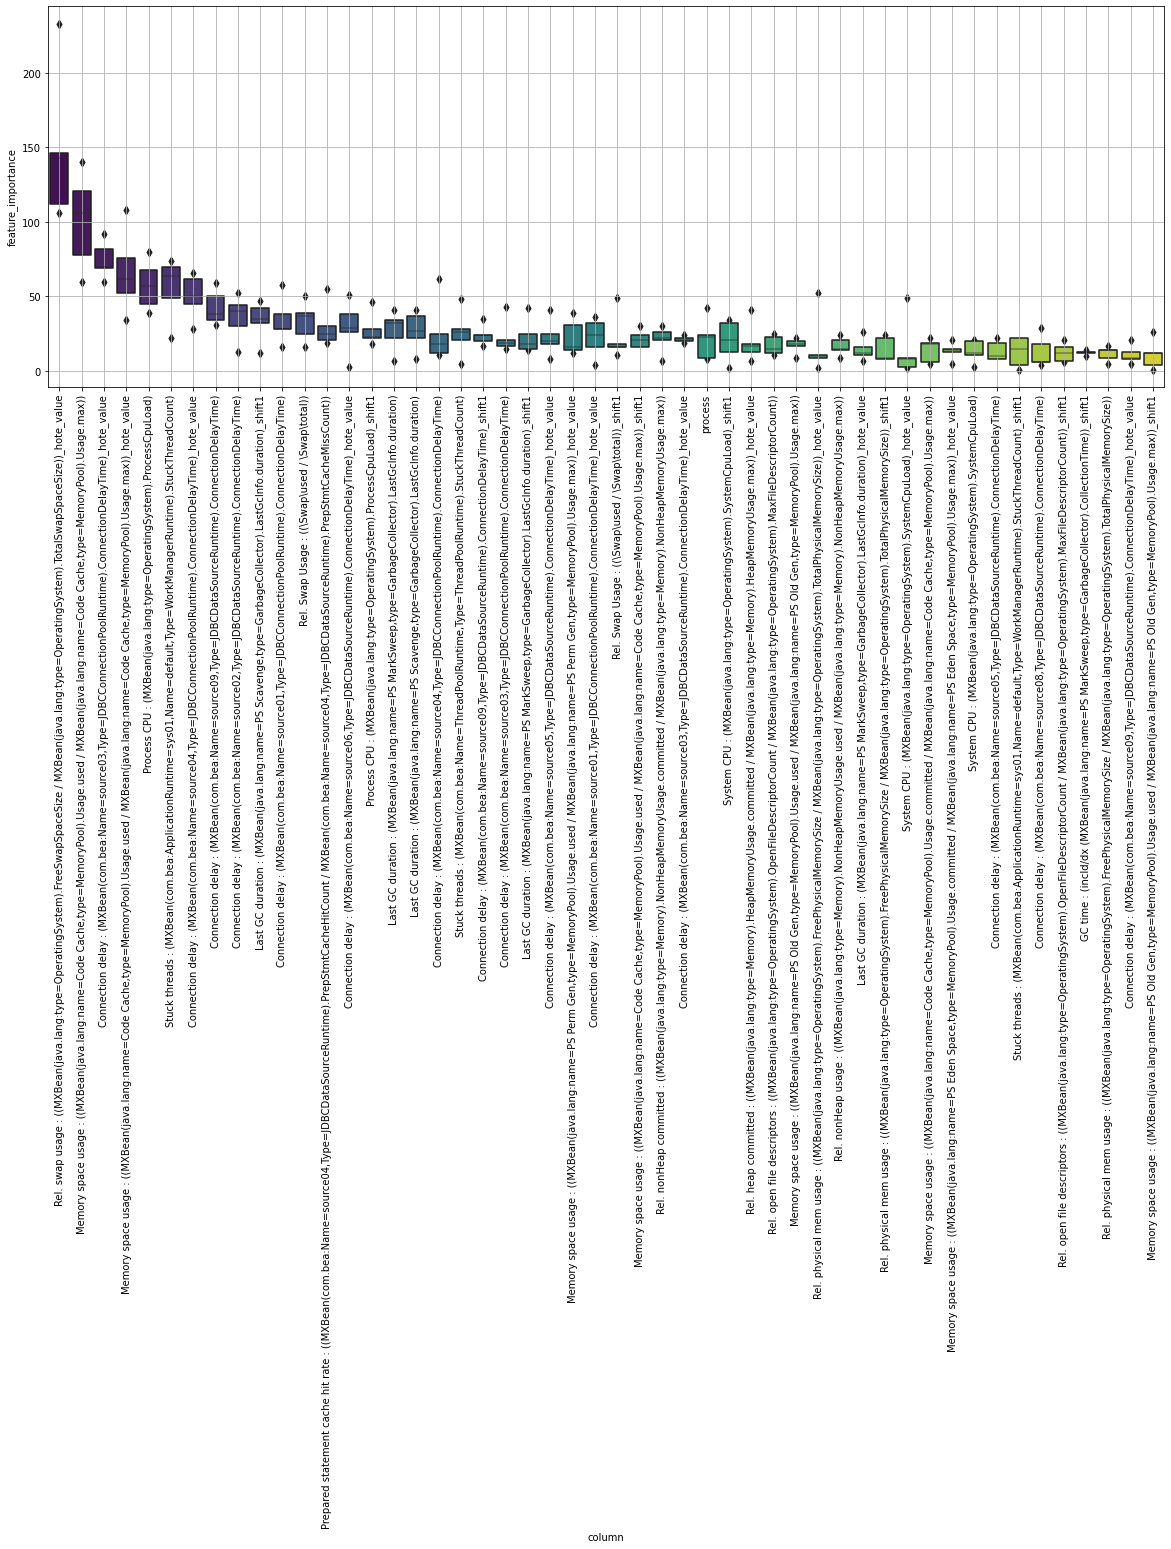

In [40]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを box plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models_lgbm, train_X)

In [41]:
del train_X, train_Y
gc.collect()

87

In [42]:
test_X.head()

,"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Prepared statement cache hit rate : ((MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source05,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))","Connection delay : (MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)",Rel. nonHeap usage : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.used / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),"Reserve request activity : (incld/dx (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ReserveRequestCount))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Active connections : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ActiveConnectionsCurrentCount)",Rel. physical mem usage : ((MXBean(java.lang:type=OperatingSystem).FreePhysicalMemorySize / MXBean(java.lang:type=OperatingSystem).TotalPhysicalMemorySize)),"Transaction committ activity : (incld/dx (MXBean(com.bea:Name=JTARuntime,Type=JTARuntime).TransactionCommittedTotalCount))","Connection delay : (MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.used / MXBean(java.lang:name=PS Old Gen,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source03,Type=JDBCConnectionPoolRuntime).CurrCapacity))","Connection delay : (MXBean(com.bea:Name=source08,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Available db connection activity : (d/dx (MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).NumAvailable))","Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCDataSourceRuntime).ConnectionDelayTime)",Swap activity : (d/dx (MXBean(java.lang:type=OperatingSystem).FreeSwapSpaceSize)),"Memory space activity : (d/dx ((MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Survivor Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source01,Type=JDBCDataSourceRuntime).CurrCapacity))",Rel. nonHeap committed : ((MXBean(java.lang:type=Memory).NonHeapMemoryUsage.committed / MXBean(java.lang:type=Memory).NonHeapMemoryUsage.max)),"Connection delay : (MXBean(com.bea:Name=source10,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source04,Type=JDBCConnectionPoolRuntime).CurrCapacity))","GC activity : (incld/dx (MXBean(java.lang:name=PS Scavenge,type=GarbageCollector).CollectionCount))","Connection delay : (MXBean(com.bea:Name=source01,Type=JDBCConnectionPoolRuntime).ConnectionDelayTime)","Connection delay : (MXBean(com.bea:Name=source02,Type=JDBCDataSourceRuntime).ConnectionDelayTime)","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCDataSourceRuntime).CurrCapacity))","Memory space activity : (d/dx ((MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.committed / MXBean(java.lang:name=PS Eden Space,type=MemoryPool).Usage.max)))","Rel. unavailable connections : ((MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).NumUnavailable / MXBean(com.bea:Name=source09,Type=JDBCConnectionPoolRuntime).CurrCapacity))",System CPU : (MXBean(java.lang:type=OperatingSystem).SystemCpuLoad),"Memory space activity : (d/dx ((MXBean(java.lang:name=Code Cache,type=MemoryPool).Usage.committed / MXBean(java.lang:name=Code Cache,type=MemoryPo

In [43]:
y_pred_lgbm = np.array([model.predict(test_X.values) for model in models_lgbm])
y_pred_lgbm = np.mean(y_pred_lgbm, axis=0)
print(len(y_pred_lgbm))
print(y_pred_lgbm[:10])

2927232
[5.11094611e-05 4.99678801e-05 4.99678801e-05 4.99678801e-05
 5.01764367e-05 5.01764367e-05 5.01764367e-05 4.99678801e-05
 4.99678801e-05 4.99678801e-05]


In [44]:
sample_submission_df = pd.read_csv(input_path + 'sample_submission.csv')

In [45]:
sample_submission_df['Anomaly'] = y_pred_lgbm
sample_submission_df.head()

,id,Anomaly
0,0,0.000051
1,1,0.000050
2,2,0.000050
3,3,0.000050
4,4,0.000050


In [46]:
sample_submission_df['Anomaly'] = sample_submission_df['Anomaly'].apply(lambda x:np.round(x))

In [47]:
sample_submission_df['Anomaly'].value_counts()

0.0    2922637
1.0       4595
Name: Anomaly, dtype: int64

In [48]:
sample_submission_df.to_csv(output_path + save_nm, index = False)

In [49]:
check_memory(dir())

|            Variable Name|    Memory|
 ------------------------------------ 
|                       In|       536|
|             LabelEncoder|      1064|
|                      Out|       656|
|     StratifiedGroupKFold|      1064|
|  average_precision_score|       144|
|                       ax|        64|
|             cal_col_list|      1008|
|               calc_prauc|       144|
|                check_col|       144|
|               check_corr|       144|
|             check_memory|       144|
|                  comment|        58|
|         competition_name|        68|
|              confirm_eda|        24|
|          cross_val_score|       144|
|                       cv|       136|
|                      day|        51|
|             des_col_list|        88|
|                    drive|        88|
|                       dt|        88|
|                     exit|        64|
|         extract_col_list|      1016|
|              extract_num|        28|
|             feature_lis